# CICY4: Data & Result Processing

In this notebook, I gather all the training curves of the 12 trained models. The models can be broadly categorized into CNN-RNN (either GRU or LSTM) hybrid architecture and LSTM-based architecture.

CNN-GRU hybrids :
 - CNN-GRU-384
 - CNN-GRU-416
 - ResNet-GRU-256
 - ResNet-GRU-400
 
CNN-LSTM hybrids:
 - CNN-LSTM-256
 - CNN-LSTM-384
 - CNN-LSTM-400
 - CNN-LSTM-416
 
LSTM-based:
 - LSTM-400
 - LSTM-424
 - LSTM-448
 - LSTM-456
The best performing model so far is CNN-LSTM-400, followed by LSTM-448 and LSTM-424.

In [1]:
import numpy as np
import pandas as pd
import os as os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import torch

In [2]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# Load full, train, validation and test sets

In [3]:
# LOAD FULL DATA BEFORE GETTING RID OF THE DIRECT MANIFOLDS
path = '/kaggle/input/calabi-yau-cicy-4-folds/'
conf = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf.npy')
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [4]:
conf = conf[~direct]
hodge = hodge[~direct]

In [5]:
#FULL DATASET AFTER GETTING RID OF DIRECT MANIFOLDS
X = conf
y = hodge
X.shape, y.shape

((905684, 16, 20), (905684, 4))

In [6]:
h11 = hodge[:,0]
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
print(f'Max h11: {h11max}, Min h11: {h11min} ')
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
print(f'Max h21: {h21max}, Min h21: {h21min} ')
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
print(f'Max h31: {h31max}, Min h31: {h31min} ')
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
print(f'Max h22: {h22max}, Min h22: {h22min} ')

Max h11: 24, Min h11: 1 
Max h21: 33, Min h21: 0 
Max h31: 426, Min h31: 20 
Max h22: 1752, Min h22: 204 


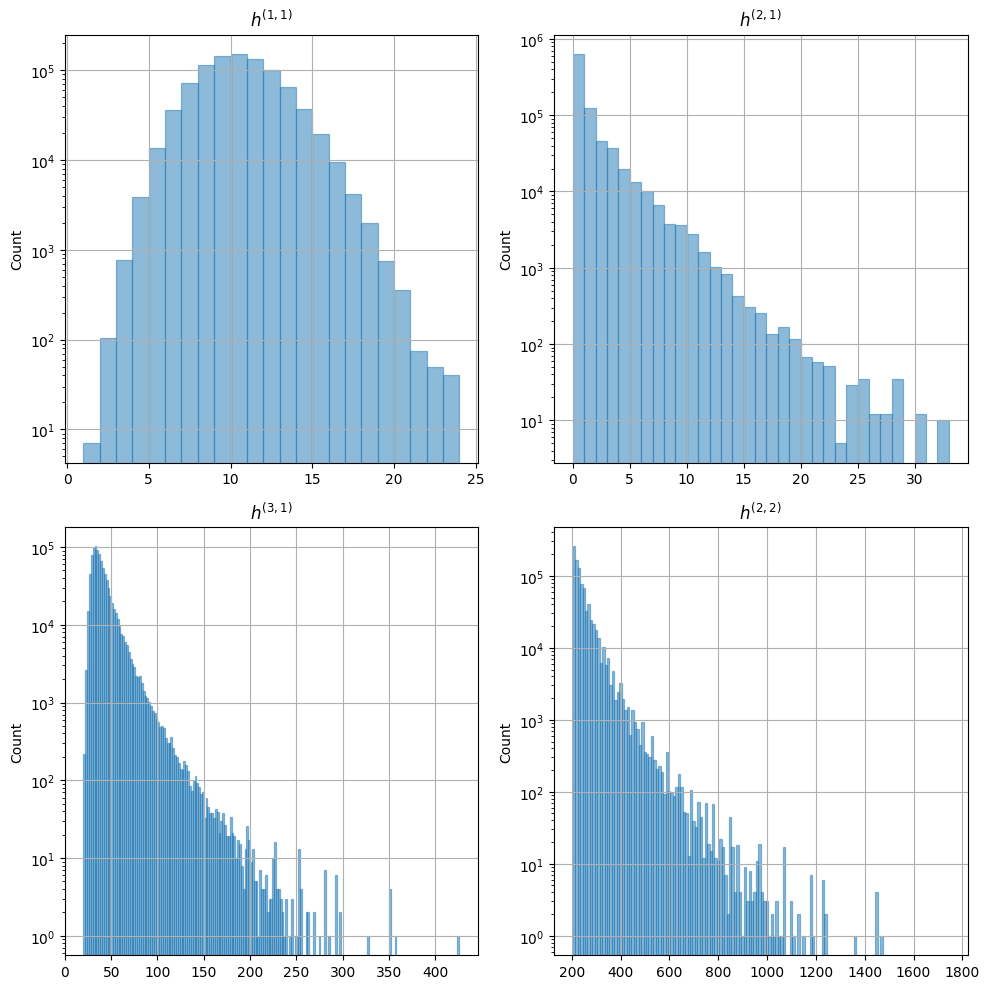

In [7]:
#REPRODUCING THE PLOT IN THE INCEPTION PAPER
style = {'edgecolor': 'C0', 'linewidth': 0.9}
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax[0,0].hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5, **style)
ax[0,0].set_title('$h^{(1,1)}$')
ax[0,0].set_ylabel('Count')
ax[0,0].grid()
ax[0,0].set_yscale('log')

ax[0,1].hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5, **style)
ax[0,1].set_title('$h^{(2,1)}$')
ax[0,1].set_ylabel('Count')
ax[0,1].grid()
ax[0,1].set_yscale('log')

ax[1,0].hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5, **style)
ax[1,0].set_title('$h^{(3,1)}$')
ax[1,0].set_ylabel('Count')
ax[1,0].grid()
ax[1,0].set_yscale('log')

ax[1,1].hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5, **style)
ax[1,1].set_title('$h^{(2,2)}$')
ax[1,1].set_ylabel('Count')
ax[1,1].grid()
ax[1,1].set_yscale('log')

plt.savefig('All_Hodge_dist')

## Load train, valid, test sets

In [8]:
#TRAIN SET
X_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtrain.npy')
y_train = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytrain.npy')

#VALIDATION SET
X_valid = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xvalid.npy')
y_valid = np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_yvalid.npy')

# TEST SET
X_test = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf_Xtest.npy')
y_test= np.load('/kaggle/input/calabi-yau-cicy-4-folds/hodge_ytest.npy')

In [9]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((652092, 16, 20),
 (72455, 16, 20),
 (181137, 16, 20),
 (652092, 4),
 (72455, 4),
 (181137, 4))

## Check the distributions of Hodge numbers in the train & test set

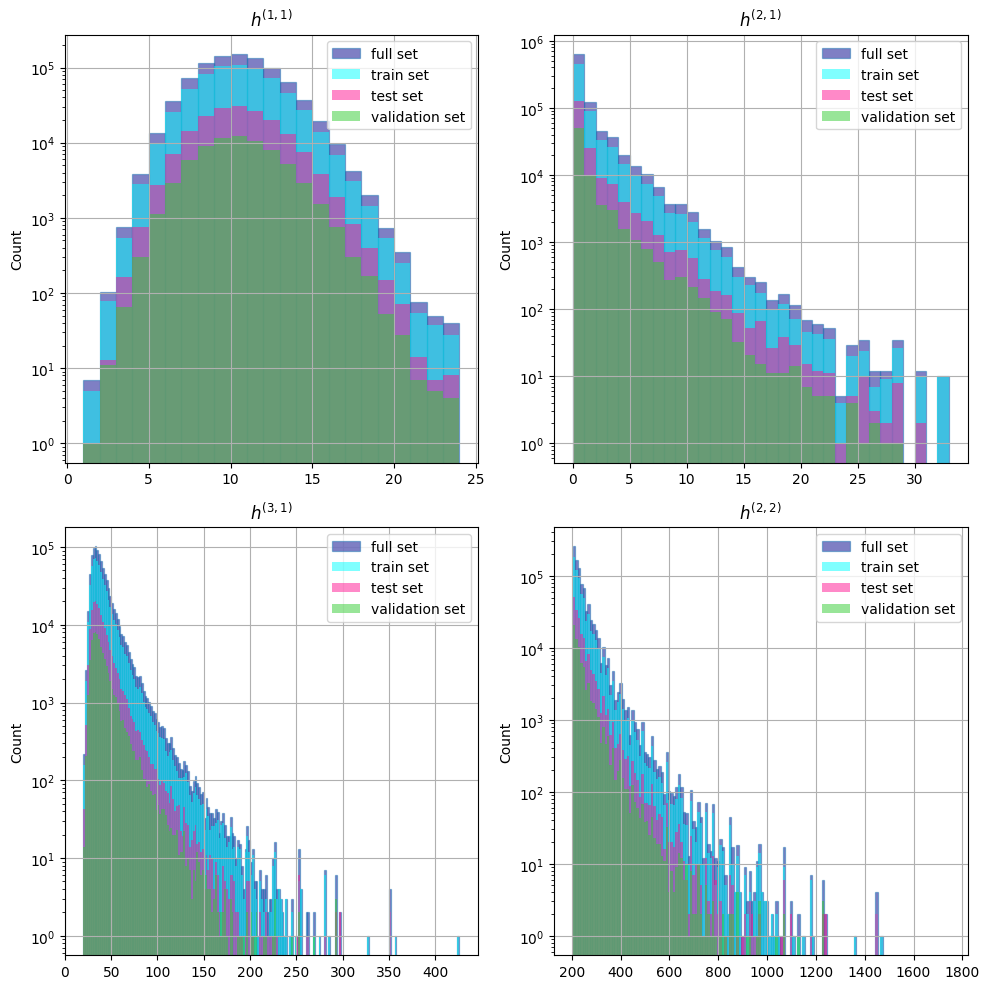

In [10]:
style = {'facecolor': 'darkblue', 'edgecolor': 'C0', 'linewidth': 0.9}
style3 = {'facecolor': 'limegreen'}
style2 = {'facecolor': 'deeppink'}
style1 = {'facecolor': 'cyan'}


fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)

ax[0,0].hist(y[:,0], bins=range(h11min, h11max+1), alpha=0.5, label = 'full set', **style)
ax[0,0].hist(y_train[:,0], bins=range(h11min, h11max+1), alpha=0.5, label = 'train set', **style1)
ax[0,0].hist(y_test[:,0], bins=range(h11min, h11max+1), alpha=0.5, label = 'test set', **style2)
ax[0,0].hist(y_valid[:,0], bins=range(h11min, h11max+1), alpha=0.5, label = 'validation set', **style3)
ax[0,0].set_title('$h^{(1,1)}$')
ax[0,0].set_ylabel('Count')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_yscale('log')

ax[0,1].hist(y[:,1], bins=range(h21min, h21max+1), alpha=0.5, label = 'full set', **style)
ax[0,1].hist(y_train[:,1], bins=range(h21min, h21max+1), alpha=0.5, label='train set',**style1)
ax[0,1].hist(y_test[:,1], bins=range(h21min, h21max+1), alpha=0.5, label='test set',**style2)
ax[0,1].hist(y_valid[:,1], bins=range(h21min, h21max+1), alpha=0.5, label='validation set',**style3)
ax[0,1].set_title('$h^{(2,1)}$')
ax[0,1].set_ylabel('Count')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_yscale('log')

ax[1,0].hist(y[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5, label='full set', **style)
ax[1,0].hist(y_train[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5, label='train set',**style1)
ax[1,0].hist(y_test[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5, label='test set',**style2)
ax[1,0].hist(y_valid[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5, label='validation set',**style3)
ax[1,0].set_title('$h^{(3,1)}$')
ax[1,0].set_ylabel('Count')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_yscale('log')

ax[1,1].hist(y[:,3], bins=range(h22min, h22max+1,10), alpha=0.5, label = 'full set', **style)
ax[1,1].hist(y_train[:,3], bins=range(h22min, h22max+1,10), alpha=0.5, label = 'train set',**style1)
ax[1,1].hist(y_test[:,3], bins=range(h22min, h22max+1,10), alpha=0.5, label = 'test set',**style2)
ax[1,1].hist(y_valid[:,3], bins=range(h22min, h22max+1,10), alpha=0.5, label = 'validation set', **style3)
ax[1,1].set_title('$h^{(2,2)}$')
ax[1,1].set_ylabel('Count')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_yscale('log')

plt.savefig('Hodge_numbers_distributions')

# Plot all training curves of the 12 trained models

## CNN-GRU hybrid models

In [11]:
loss_dict_cnn_gru = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-cnn-gru-384.csv')
loss_dict_cnn_gru_416 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-cnn-gru-416.csv')
loss_dict_resnet_gru_256 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-resnet-gru-256.csv')
loss_dict_resnet_gru_400 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-resnet-gru-400.csv')

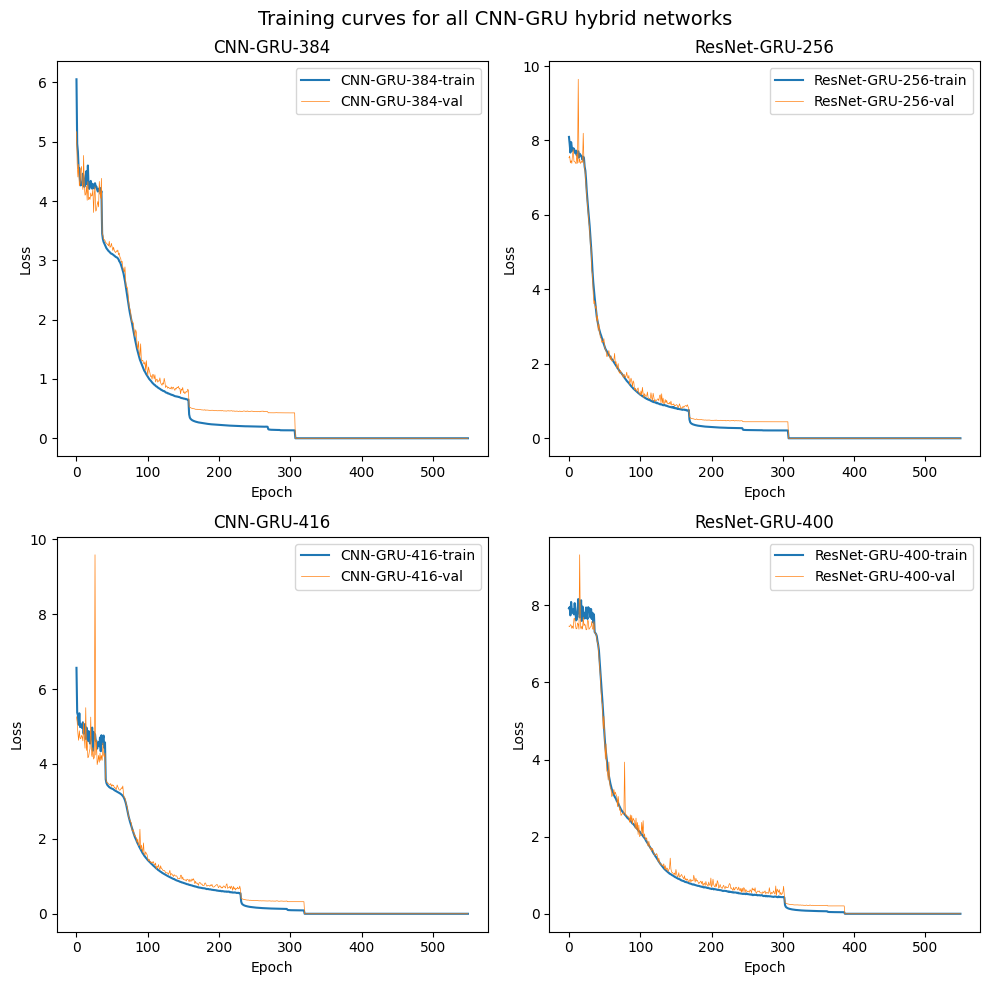

In [12]:
#CNN-GRU NORMAL SCALE
fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_gru[['train_loss']], label = 'CNN-GRU-384-train')
ax[0,0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384-val',linewidth = 0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('CNN-GRU-384')
ax[0,0].legend()

ax[0,1].plot(loss_dict_resnet_gru_256[['train_loss']], label = 'ResNet-GRU-256-train')
ax[0,1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256-val',linewidth = 0.5)
ax[0,1].set_title('ResNet-GRU-256')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_cnn_gru_416[['train_loss']], label = 'CNN-GRU-416-train')
ax[1,0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416-val',linewidth = 0.5)
ax[1,0].set_title('CNN-GRU-416')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_resnet_gru_400[['train_loss']], label = 'ResNet-GRU-400-train')
ax[1,1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400-val',linewidth = 0.5)
ax[1,1].set_title('ResNet-GRU-400')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()

fig.suptitle('Training curves for all CNN-GRU hybrid networks', fontsize = 14)
plt.savefig('CNN_GRU-ResNet_GRU_train-val_losses')

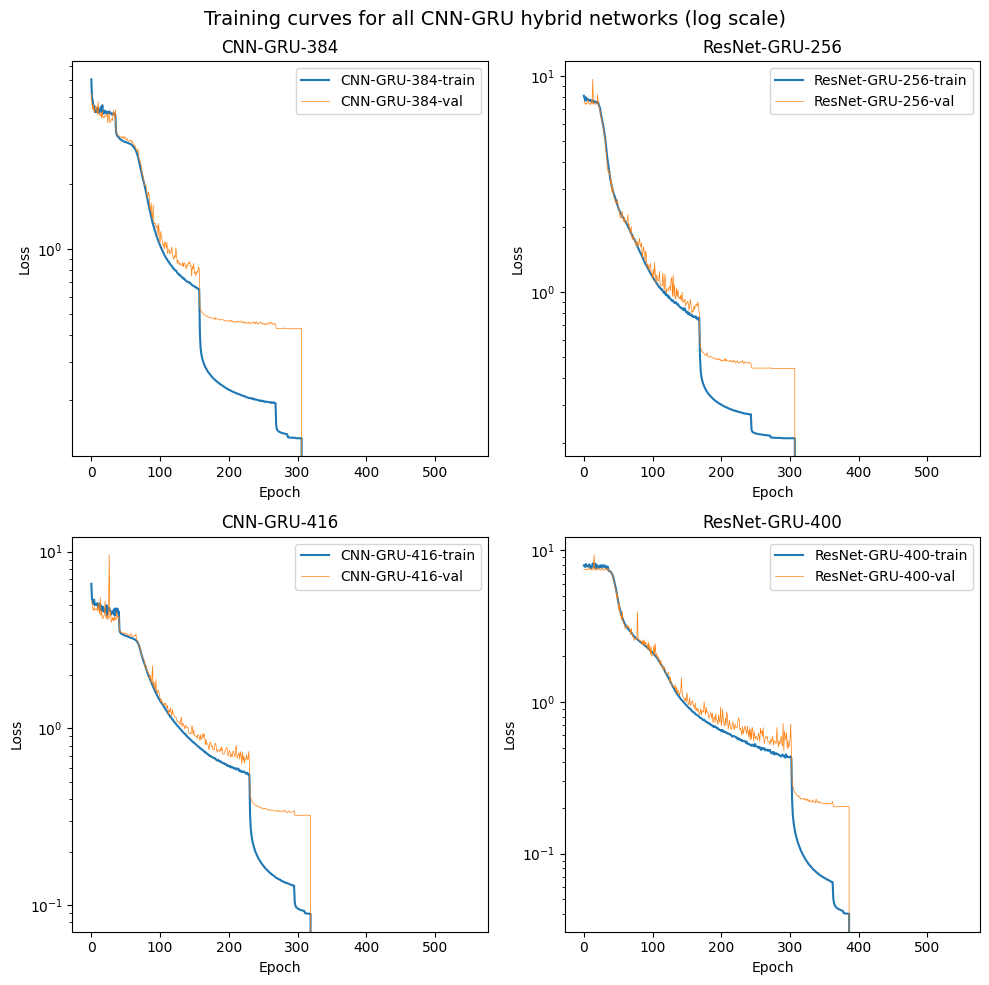

In [13]:
#CNN-GRU LOG SCALE
fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_gru[['train_loss']], label = 'CNN-GRU-384-train')
ax[0,0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384-val',linewidth = 0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('CNN-GRU-384')
ax[0,0].legend()
ax[0,0].set_yscale('log')

ax[0,1].plot(loss_dict_resnet_gru_256[['train_loss']], label = 'ResNet-GRU-256-train')
ax[0,1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256-val',linewidth = 0.5)
ax[0,1].set_title('ResNet-GRU-256')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()
ax[0,1].set_yscale('log')

ax[1,0].plot(loss_dict_cnn_gru_416[['train_loss']], label = 'CNN-GRU-416-train')
ax[1,0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416-val',linewidth = 0.5)
ax[1,0].set_title('CNN-GRU-416')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_resnet_gru_400[['train_loss']], label = 'ResNet-GRU-400-train')
ax[1,1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400-val',linewidth = 0.5)
ax[1,1].set_title('ResNet-GRU-400')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
ax[1,1].set_yscale('log')

fig.suptitle('Training curves for all CNN-GRU hybrid networks (log scale)', fontsize = 14)
plt.savefig('CNN_GRU-ResNet_GRU_train-val_losses_logscale')

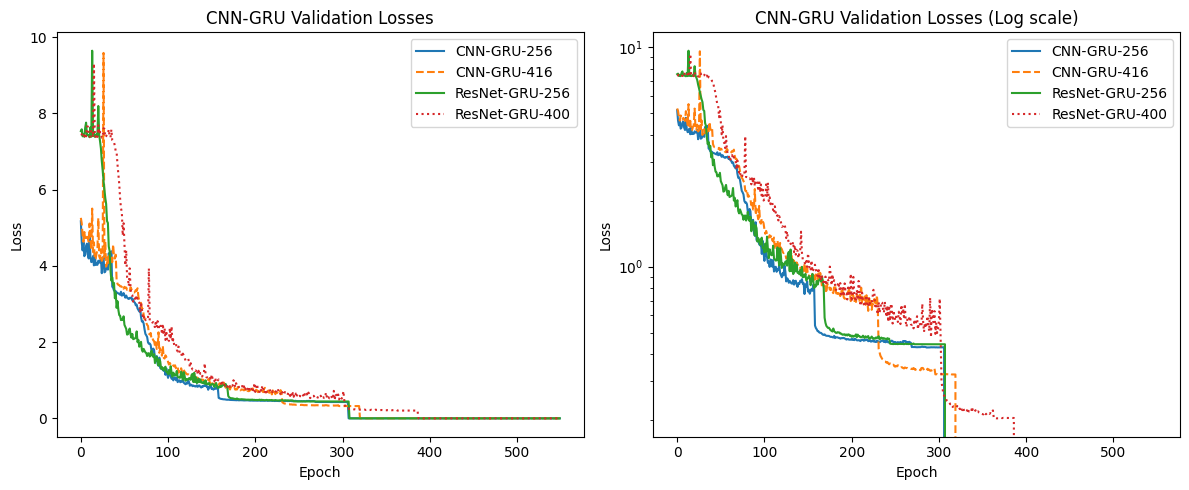

In [14]:
#CNN-GRU ALL MODELS PLOTTED TOGETHER
fig, ax = plt.subplots(1,2, figsize = (12,5), tight_layout = True)
ax[0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-256')
ax[0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416', linestyle = 'dashed')
ax[0].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256')
ax[0].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400', linestyle = 'dotted')
ax[0].set_title('CNN-GRU Validation Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-256')
ax[1].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416', linestyle = 'dashed')
ax[1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256')
ax[1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400',  linestyle = 'dotted')
ax[1].set_title('CNN-GRU Validation Losses (Log scale)')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
plt.savefig('CNN-GRU_all_losses')

## CNN-LSTM hybrid models

In [15]:
loss_dict_cnn_lstm_256 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_cnn_lstm_256.csv')
loss_dict_cnn_lstm_384 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_cnn_lstm_384.csv')
loss_dict_cnn_lstm_400 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_cnn_lstm_400.csv')
loss_dict_cnn_lstm_416 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_cnn_lstm_416.csv')

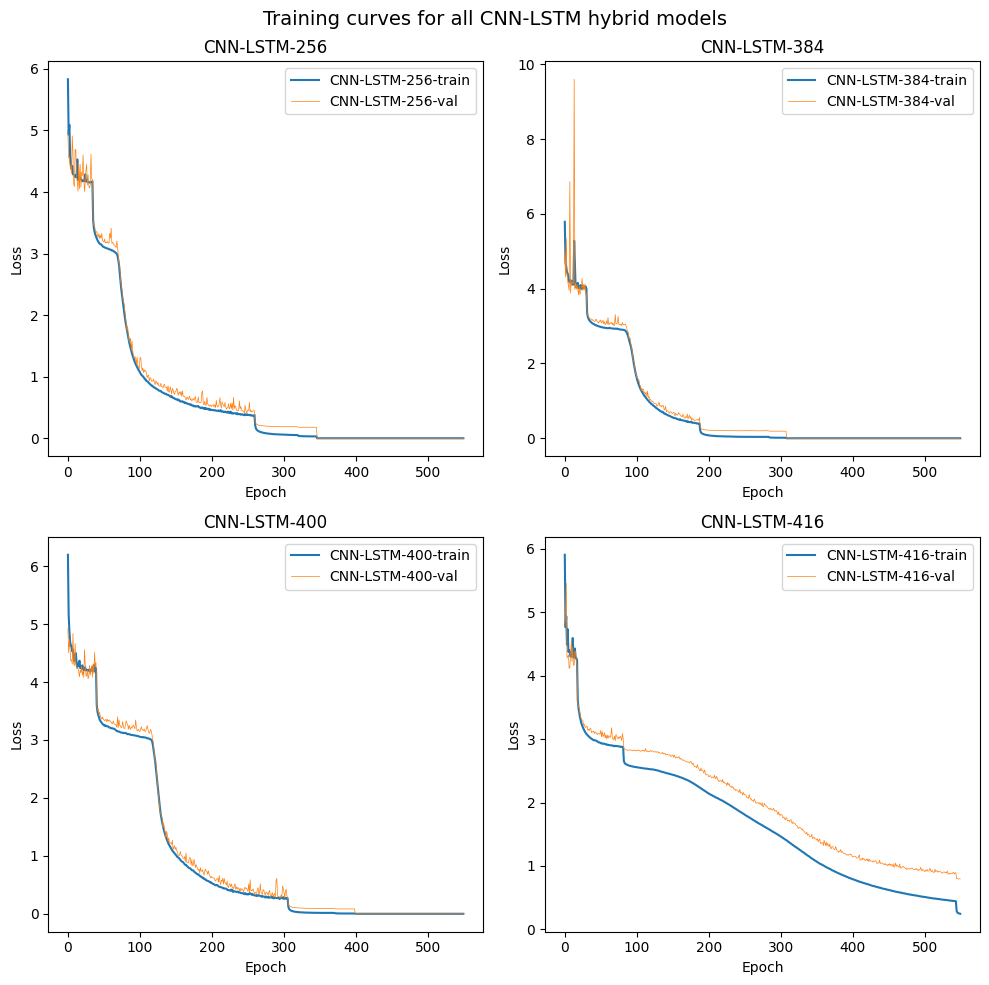

In [16]:
#CNN-LSTM NORMAL SCALE
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_lstm_256[['train_loss']], label = 'CNN-LSTM-256-train')
ax[0,0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256-val',linewidth = 0.5)
ax[0,0].set_title('CNN-LSTM-256')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()

ax[0,1].plot(loss_dict_cnn_lstm_384[['train_loss']], label = 'CNN-LSTM-384-train')
ax[0,1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384-val',linewidth = 0.5)
ax[0,1].set_title('CNN-LSTM-384')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_cnn_lstm_400[['train_loss']], label = 'CNN-LSTM-400-train')
ax[1,0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400-val',linewidth = 0.5)
ax[1,0].set_title('CNN-LSTM-400')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_cnn_lstm_416[['train_loss']], label = 'CNN-LSTM-416-train')
ax[1,1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416-val',linewidth = 0.5)
ax[1,1].set_title('CNN-LSTM-416')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()

plt.suptitle('Training curves for all CNN-LSTM hybrid models', fontsize = 14)
plt.savefig('CNN_LSTM_train-val_losses')

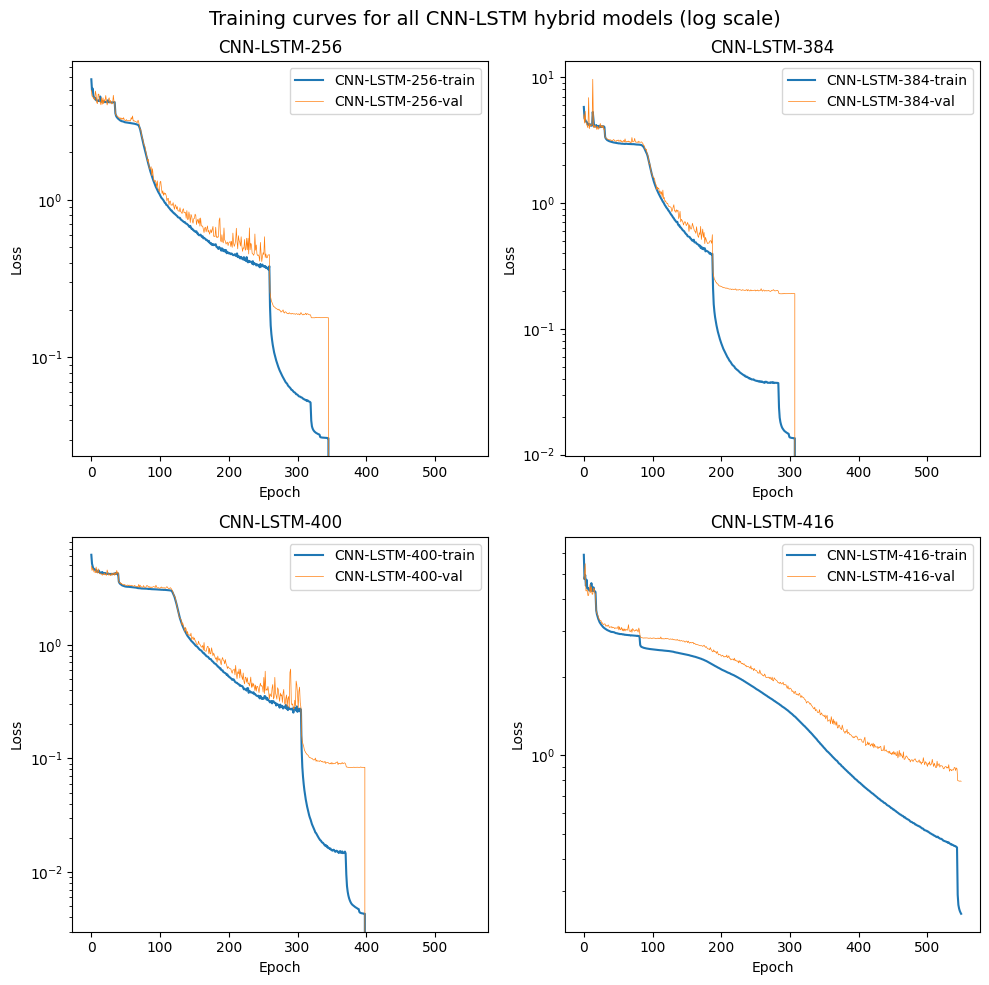

In [17]:
#CNN-LSTM LOG SCALE
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_lstm_256[['train_loss']], label = 'CNN-LSTM-256-train')
ax[0,0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256-val',linewidth = 0.5)
ax[0,0].set_title('CNN-LSTM-256')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_yscale('log')


ax[0,1].plot(loss_dict_cnn_lstm_384[['train_loss']], label = 'CNN-LSTM-384-train')
ax[0,1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384-val',linewidth = 0.5)
ax[0,1].set_title('CNN-LSTM-384')
ax[0,1].legend()
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_yscale('log')


ax[1,0].plot(loss_dict_cnn_lstm_400[['train_loss']], label = 'CNN-LSTM-400-train')
ax[1,0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400-val', linewidth = 0.5)
ax[1,0].set_title('CNN-LSTM-400')
ax[1,0].legend()
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_cnn_lstm_416[['train_loss']], label = 'CNN-LSTM-416-train')
ax[1,1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416-val', linewidth = 0.5)
ax[1,1].set_title('CNN-LSTM-416')
ax[1,1].legend()
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_yscale('log')

plt.suptitle('Training curves for all CNN-LSTM hybrid models (log scale)', fontsize = 14)
plt.savefig('CNN_LSTM_train-val_losses_logscale')

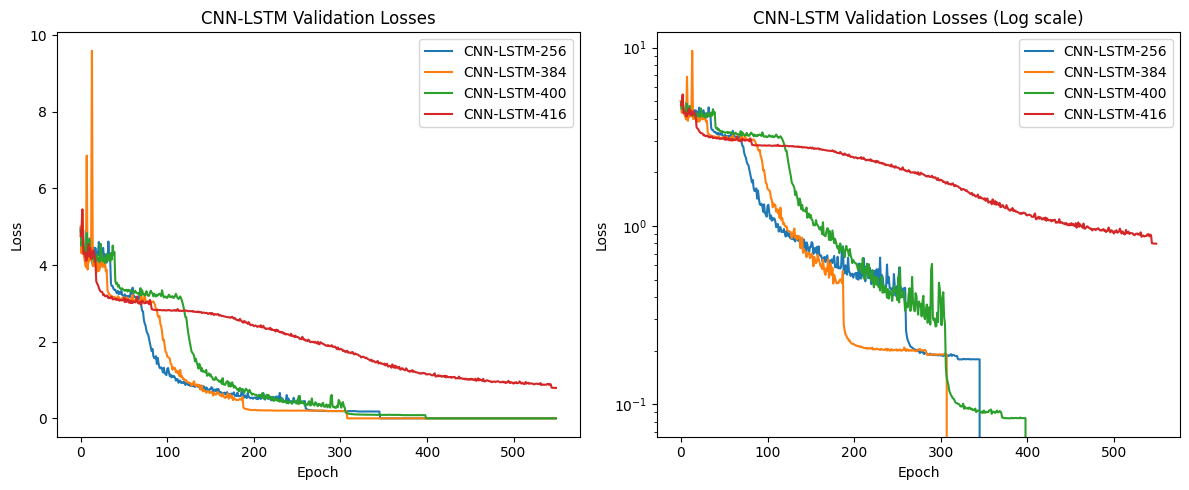

In [18]:
#CNN-LSTM ALL MODELS PLOTTED TOGETHER
fig, ax = plt.subplots(1,2, figsize = (12,5), tight_layout = True)
ax[0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256')
ax[0].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax[0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400')
ax[0].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('CNN-LSTM Validation Losses')
ax[0].legend()

ax[1].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256')
ax[1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax[1].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400')
ax[1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416')
ax[1].set_title('CNN-LSTM Validation Losses (Log scale)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_yscale('log')
plt.savefig('CNN_LSTM_all_val_losses_logscale')

## CNN-LSTM vs CNN-GRU

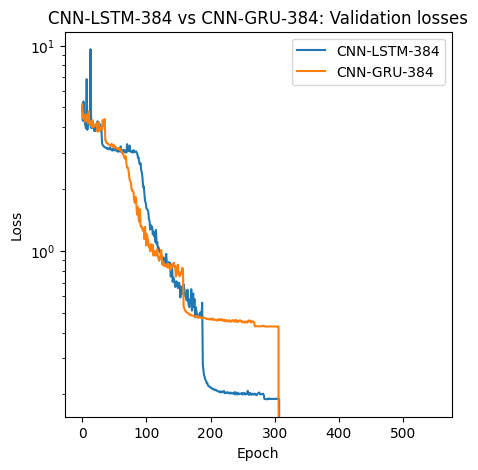

In [19]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax.plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384')
ax.set_title('CNN-LSTM-384 vs CNN-GRU-384: Validation losses')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.savefig('LSTM_vs_GRU')

## LSTM-based models

In [20]:
loss_dict_lstm_400 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_lstm_400.csv')
loss_dict_lstm_424 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-lstm-424.csv')
loss_dict_lstm_448 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss-dict-lstm-448.csv')
loss_dict_lstm_456 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/train-validation-losses/loss_dict_lstm_456.csv')

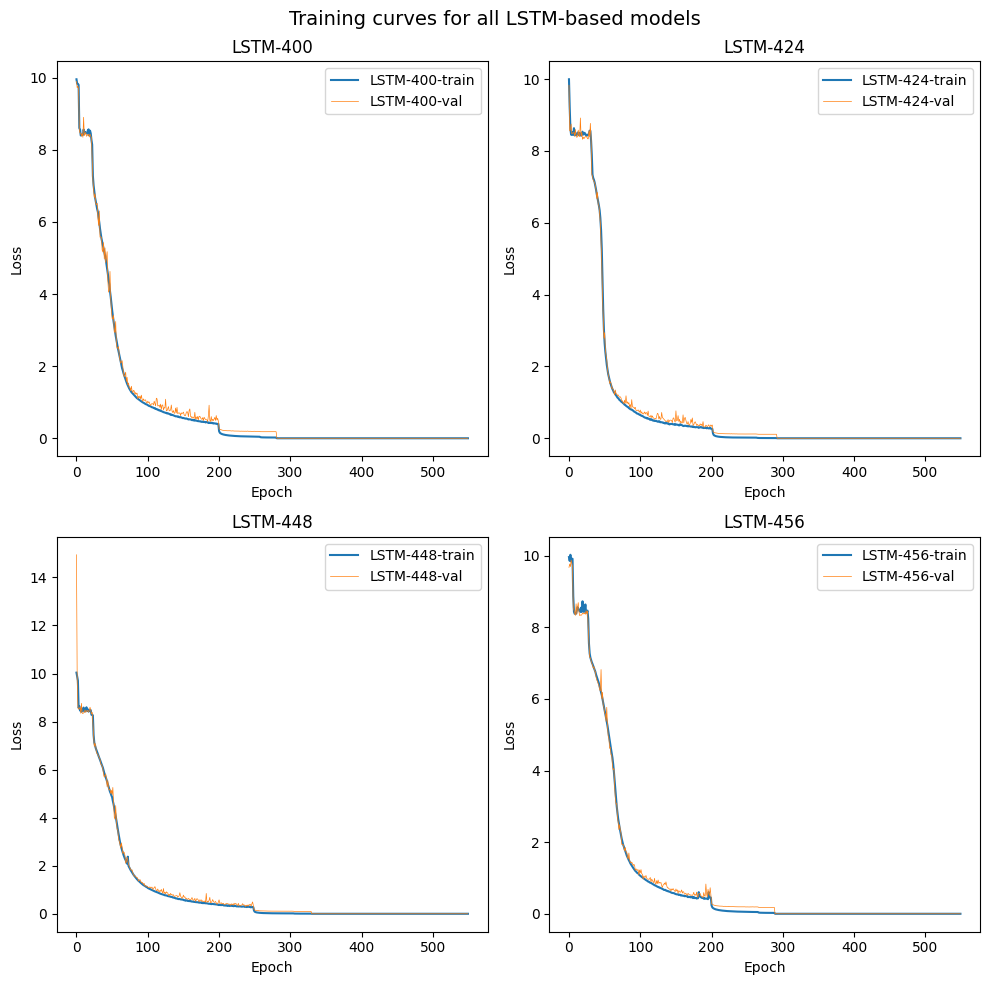

In [21]:
#LSTM MODELS NORMAL SCALE
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)

ax[0,0].plot(loss_dict_lstm_400[['train_loss']], label = 'LSTM-400-train')
ax[0,0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400-val',linewidth = 0.5)
ax[0,0].set_title('LSTM-400')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()

ax[0,1].plot(loss_dict_lstm_424[['train_loss']], label = 'LSTM-424-train')
ax[0,1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424-val',linewidth = 0.5)
ax[0,1].set_title('LSTM-424')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_lstm_448[['train_loss']], label = 'LSTM-448-train')
ax[1,0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448-val',linewidth = 0.5)
ax[1,0].set_title('LSTM-448')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_lstm_456[['train_loss']], label = 'LSTM-456-train')
ax[1,1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456-val',linewidth = 0.5)
ax[1,1].set_title('LSTM-456')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
plt.suptitle('Training curves for all LSTM-based models', fontsize = 14)
plt.savefig('LSTM_train-val_losses_all')

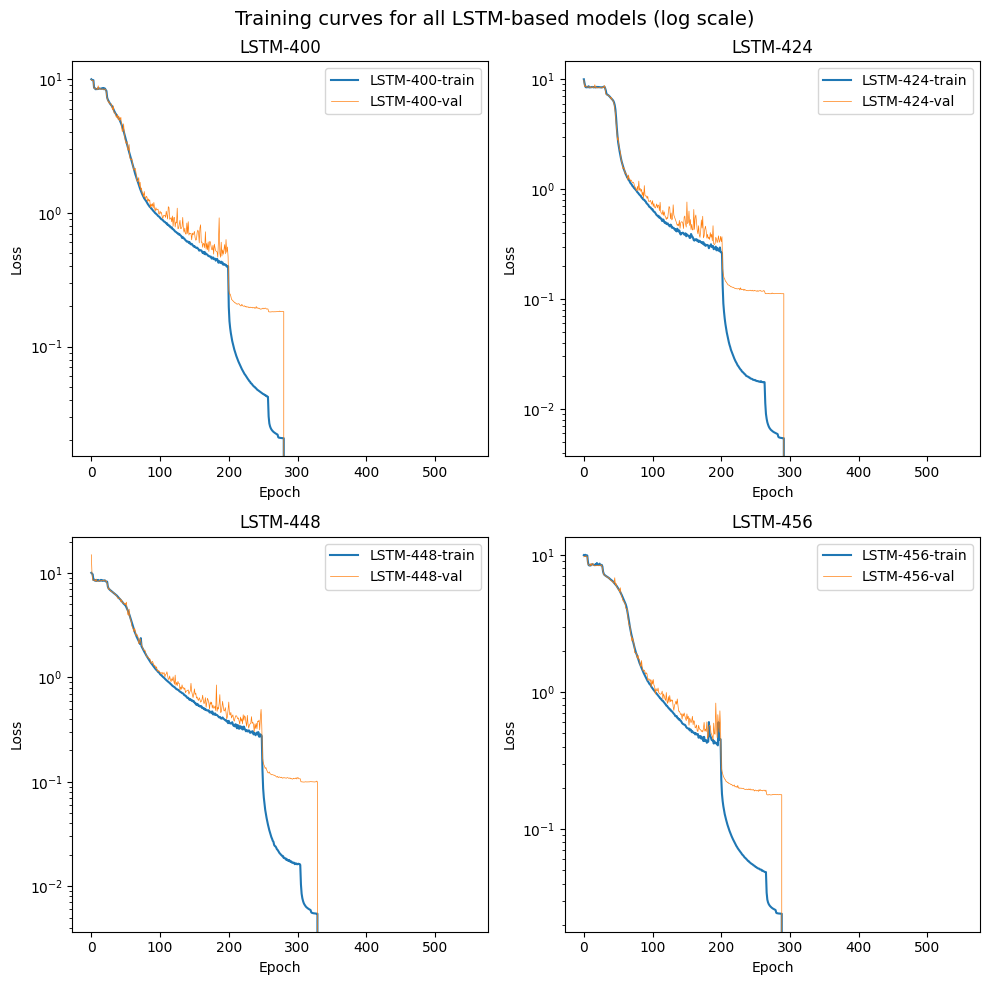

In [22]:
#LSTM MODELS LOG SCALE
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)

ax[0,0].plot(loss_dict_lstm_400[['train_loss']], label = 'LSTM-400-train')
ax[0,0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400-val',linewidth = 0.5)
ax[0,0].set_title('LSTM-400')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()
ax[0,0].set_yscale('log')

ax[0,1].plot(loss_dict_lstm_424[['train_loss']], label = 'LSTM-424-train')
ax[0,1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424-val',linewidth = 0.5)
ax[0,1].set_title('LSTM-424')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()
ax[0,1].set_yscale('log')

ax[1,0].plot(loss_dict_lstm_448[['train_loss']], label = 'LSTM-448-train')
ax[1,0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448-val',linewidth = 0.5)
ax[1,0].set_title('LSTM-448')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_lstm_456[['train_loss']], label = 'LSTM-456-train')
ax[1,1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456-val',linewidth = 0.5)
ax[1,1].set_title('LSTM-456')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
ax[1,1].set_yscale('log')

plt.suptitle('Training curves for all LSTM-based models (log scale)', fontsize = 14)
plt.savefig('LSTM_train-val_losses_logscale')

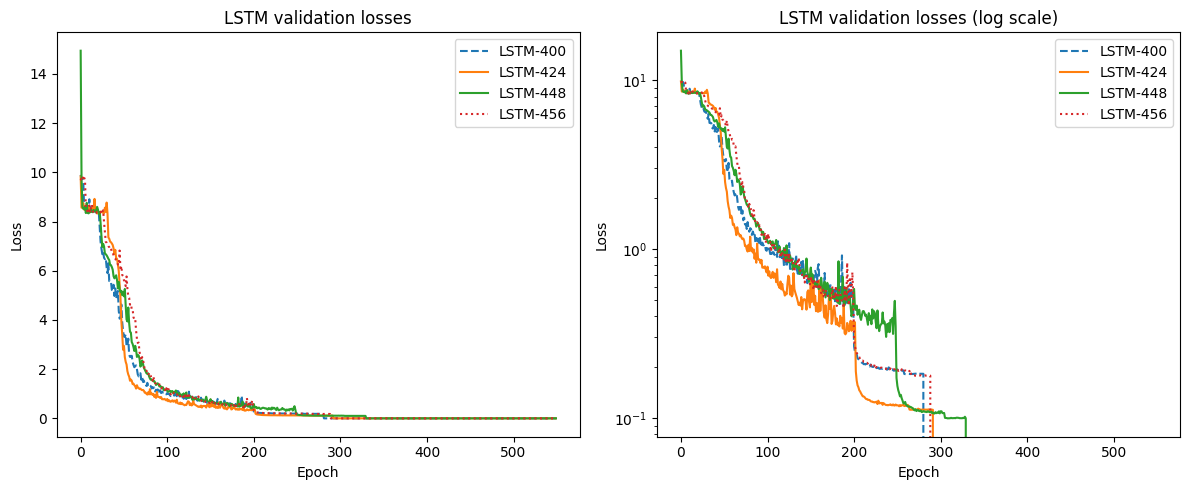

In [23]:
# LSTM MODELS PLOTTED TOGETHER
fig, ax = plt.subplots(1,2, figsize = (12, 5), tight_layout = True)
ax[0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400', linestyle = 'dashed')
ax[0].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424')
ax[0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448')
ax[0].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456', linestyle = 'dotted')
ax[0].set_title('LSTM validation losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400', linestyle = 'dashed')
ax[1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424')
ax[1].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448')
ax[1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456', linestyle = 'dotted')
ax[1].set_title('LSTM validation losses (log scale)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_yscale('log')
plt.savefig('LSTM_train-val_losses')

# Check model performances using last validation loss

In [24]:
loss_list = [loss_dict_cnn_gru,loss_dict_cnn_gru_416, loss_dict_resnet_gru_256,loss_dict_resnet_gru_400, 
            loss_dict_cnn_lstm_256, loss_dict_cnn_lstm_384, loss_dict_cnn_lstm_400, 
             loss_dict_lstm_400, loss_dict_lstm_424,loss_dict_lstm_448, loss_dict_lstm_456]

name_list = ['CNN-GRU-384','CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400',
    'CNN-LSTM-256', 'CNN-LSTM-384', 
       'CNN-LSTM-400',
     'LSTM-400','LSTM-424','LSTM-448','LSTM-456']

loss_dict = {name_list[i]: loss_list[i] for i in range(len(loss_list))}
loss_dict.keys()

dict_keys(['CNN-GRU-384', 'CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400', 'CNN-LSTM-256', 'CNN-LSTM-384', 'CNN-LSTM-400', 'LSTM-400', 'LSTM-424', 'LSTM-448', 'LSTM-456'])

In [25]:
loss_dict_cnn_lstm_256.columns = ['train_loss', 'test_loss']
loss_dict_cnn_lstm_400.columns = ['train_loss', 'test_loss']
loss_dict_cnn_lstm_384.columns = ['train_loss', 'test_loss']

In [26]:
#write a function to check for the last nonzero value
def check_last_nonzero(df, model_name):
    for i in range(len(df)):
        if df['train_loss'][i] == 0 and df['train_loss'][i+1] == 0:
            return model_name, i-1, df['train_loss'][i-1], df['test_loss'][i-1]
        
last_val_list = [check_last_nonzero(loss_list[i], name_list[i]) for i in range(len(loss_list))]
last_val_list

[('CNN-GRU-384', 306, 0.1337970497008044, 0.4283022789622951),
 ('CNN-GRU-416', 319, 0.0894559652497946, 0.3220232229883498),
 ('ResNet-GRU-256', 307, 0.2098858948032919, 0.4422456975862042),
 ('ResNet-GRU-400', 386, 0.0401238790269981, 0.2039496767904602),
 ('CNN-LSTM-256', 345, 0.0306385038248734, 0.1785419213715316),
 ('CNN-LSTM-384', 307, 0.0134794706793116, 0.1899900773188634),
 ('CNN-LSTM-400', 398, 0.0043023051301033, 0.0835543588342595),
 ('LSTM-400', 280, 0.0206438472146265, 0.1825886086233919),
 ('LSTM-424', 291, 0.0054046038589856, 0.1117993761675277),
 ('LSTM-448', 329, 0.0054459169049134, 0.0996007998163912),
 ('LSTM-456', 288, 0.0241062974712653, 0.178004607321724)]

In [27]:
#write a new csv file
mds2 = [last_val_list[i][0] for i in range(len(last_val_list))]
last_train =[last_val_list[i][2] for i in range(len(last_val_list))]
last_test =[last_val_list[i][3] for i in range(len(last_val_list))]

val_dict = {'last_train': last_train, 'last_val': last_test}
df2 = pd.DataFrame(val_dict, index = mds2)
df2.to_csv('train_test_last_val.csv')
df2

,last_train,last_val
CNN-GRU-384,0.133797,0.428302
CNN-GRU-416,0.089456,0.322023
ResNet-GRU-256,0.209886,0.442246
ResNet-GRU-400,0.040124,0.203950
CNN-LSTM-256,0.030639,0.178542
CNN-LSTM-384,0.013479,0.189990
CNN-LSTM-400,0.004302,0.083554
LSTM-400,0.020644,0.182589
LSTM-424,0.005405,0.111799
LSTM-448,0.005446,0.099601


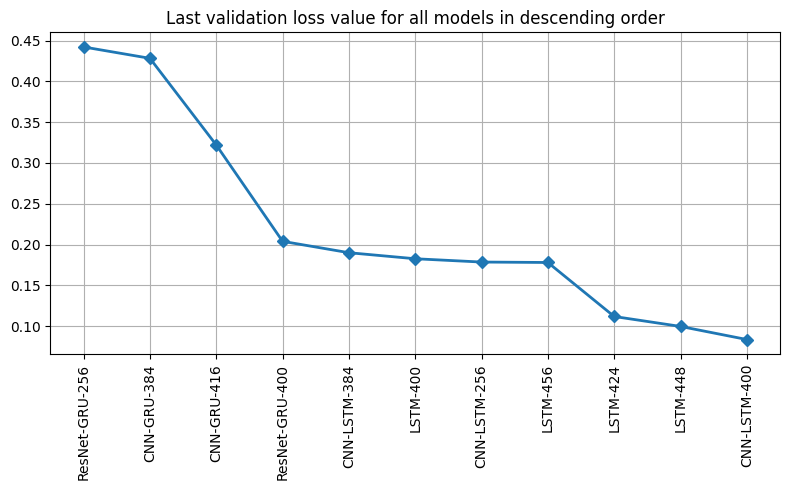

In [28]:
fig, ax = plt.subplots(figsize = (8,5), tight_layout = True)
df_lt = df2['last_val'].sort_values(ascending = False)
df_ltr = df2['last_train'].sort_values(ascending = False)
df_lt.plot(ax = ax, style='D-', linewidth = 2)
ax.grid()
ax.set_title('Last validation loss value for all models in descending order')
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticks(range(len(df2.index)))
ax.set_xticklabels(df_lt.index)

plt.savefig('Last_train_test_loss_values.png')